In [ ]:
import thorlabs_apt as apt
import usb.core
import usb.util
import subprocess
import time
import threading
import matplotlib.pyplot as plt
from multiprocessing import Process
import numpy as np
from scipy.interpolate import griddata
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
l = apt.list_available_devices()
print(l)

In [ ]:
#define motors
#motor = l([0][1])
x = apt.Motor(l[3][1])
y = apt.Motor(l[2][1])

y.set_stage_axis_info(-2.0, 20.0, 1, 0.5)
x.set_stage_axis_info(-2.0, 20.0, 1, 0.5)

In [18]:
exe_path = "C:\\Users\\opticslab\\Documents\\picoFiles\\example\\smarACT\\x64\\Debug\\smarACT.exe"

def collect_data():
    #try:
   # exe_process = subprocess.run([exe_path],capture_output=True, text=True)
    #print("call")
    exe_process = subprocess.Popen(exe_path, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, )
    output, error = exe_process.communicate()
    d = output.decode()

    return d

   # print(output.decode())
    #if(exe_process.returncode == 0 ):
     #   n = exe_process.stdout.strip()
    #print(n)

    #print("running")
    #except subprocess.CalledProcessError as e:
     #   print(f"error: {e}")


In [ ]:
print(x.position)
print(y.position)

In [171]:
x.position = 0
y.position = 0

In [172]:
x_initial = 0   # mm
y_initial = 0

x.position = x_initial
y.position = y_initial

while(x.is_in_motion or y.is_in_motion ):
    time.sleep


scan_width = 6
step_size = .25

num_steps = int(scan_width / step_size)
num_rows = int(scan_width / step_size)

xp = []
yp = []
h= []

print("begin scan")
xp.append(x.position)
yp.append(y.position)
d = collect_data()
h.append(int(d.strip()))

start = time.time()
for row in range(num_rows):
    if row % 2 == 0:
        start_x = 0
        end_x = scan_width
        step_direction = 1
    else:
        start_x = scan_width
        end_x = 0
        step_direction = -1
    x.move_to(start_x)
    while(x.is_in_motion):
        time.sleep
    
    for step in range(num_steps):
        current_x = start_x + step_direction * step * step_size
        x.move_to(current_x)
        while(x.is_in_motion):
            time.sleep
        
        d = collect_data()
        print("x position: %1.10f" % x.position, "y position: %1.10f" % y.position, "height: %1.10f" % (int(d.strip())*(10**-12)))
        xp.append(x.position)
        yp.append(y.position)
        h.append(int(d.strip()))

    y.move_to(( row+1) * step_size )
    while(y.is_in_motion):
        time.sleep


print("scan complete, time elapsed [s]: ", time.time() - start)

        



begin scan
x position: 0.0000000000 y position: 0.0000000000 height: -0.0002072294
x position: 0.2500000000 y position: 0.0000000000 height: -0.0002048453
x position: 0.5000000000 y position: 0.0000000000 height: -0.0001979222
x position: 0.7500000000 y position: 0.0000000000 height: -0.0002055685
x position: 1.0000000000 y position: 0.0000000000 height: -0.0002047275
x position: 1.2500000000 y position: 0.0000000000 height: -0.0002076328
x position: 1.5000000000 y position: 0.0000000000 height: -0.0002182386
x position: 1.7500000000 y position: 0.0000000000 height: -0.0002102206
x position: 2.0000000000 y position: 0.0000000000 height: -0.0002079060
x position: 2.2499592304 y position: 0.0000000000 height: -0.0002047515
x position: 2.5000000000 y position: 0.0000000000 height: -0.0002060312
x position: 2.7500000000 y position: 0.0000000000 height: -0.0002097472
x position: 3.0000000000 y position: 0.0000000000 height: -0.0002115478
x position: 3.2499592304 y position: 0.0000000000 hei

In [173]:

d = np.column_stack((xp,yp,h))
#Change file name before saving 
np.savetxt("C:\\Users\\opticslab\\Documents\\picoFiles\\smaract_logo_scan_6x6mm.txt",d,delimiter=" ")

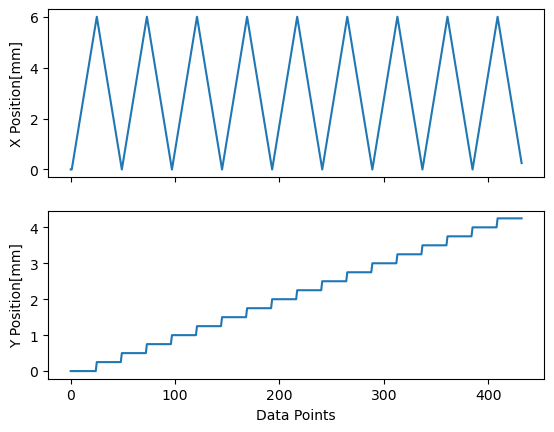

In [174]:

#graph of x-motor position
fig,axs = plt.subplots(2, sharex=True)
axs[0].plot(xp)
axs[0].set(ylabel = 'X Position[mm]')

axs[1].set(ylabel = 'Y Position[mm]',xlabel='Data Points')
axs[1].plot(yp)
plt.show()

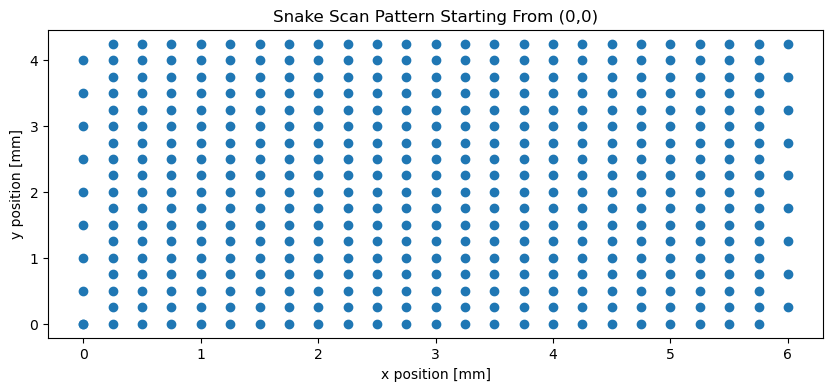

In [175]:
plt.figure(figsize=(10,4))
plt.title("Snake Scan Pattern Starting From (0,0)")
plt.scatter(xp,yp)
plt.xlabel('x position [mm]')
plt.ylabel('y position [mm]')
plt.show()

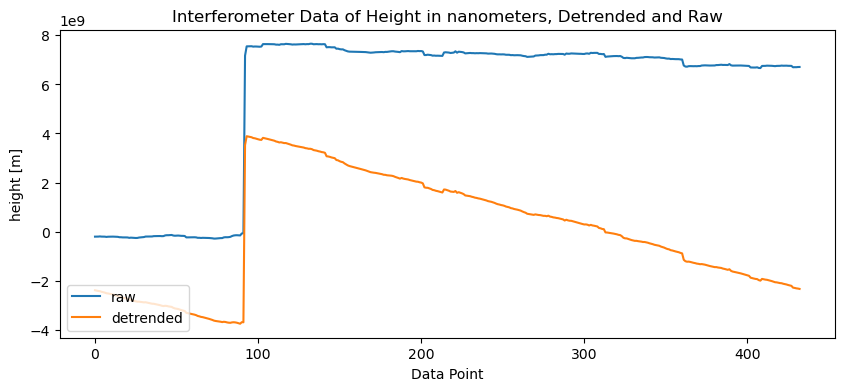

In [176]:
# normalizing the height data and replotting 
h_detrended = signal.detrend(h)
plt.figure(figsize=(10, 4))
plt.title("Interferometer Data of Height in nanometers, Detrended and Raw")
plt.plot(h, label ="raw")
plt.plot(h_detrended, label="detrended")
plt.xlabel('Data Point')
plt.ylabel('height [m]')
plt.legend(loc='lower left')


plt.show()

In [179]:
#reconstruct surface using interpolatate
from scipy import interpolate


Nx = len(xp)
Ny = len(yp)

x_lin = np.linspace(min(xp), max(xp), Nx)
y_lin = np.linspace(min(yp), max(yp), Ny)

X, Y = np.meshgrid(xp,yp)

WASH = griddata((xp,yp),h,(X,Y),method='nearest')

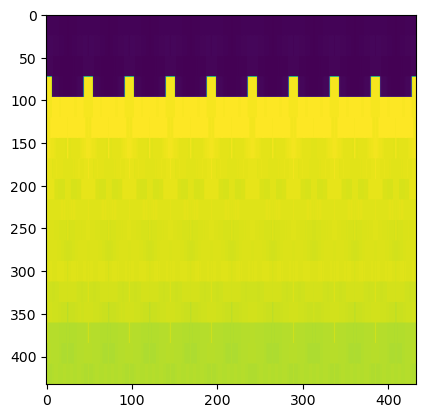

In [180]:
plt.imshow(WASH)
plt.show()

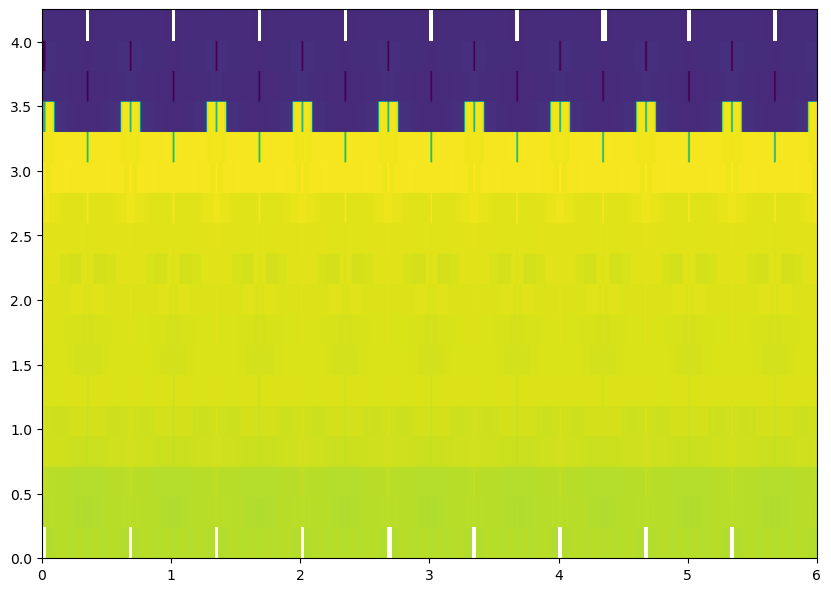

In [183]:
X, Y = np.meshgrid(xp,yp)
z = np.array(h_detrended)

Z = griddata((xp,yp),h,(X,Y), method='cubic')
fig = plt.figure(figsize=(10,10))
plt.imshow(Z, extent=[min(xp),max(xp),min(yp),max(yp)])

plt.show()


In [1]:
X, Y = np.meshgrid(xp,yp)
z = np.array(h_detrended)

Z = griddata((xp,yp),h_detrended,(X,Y), method='nearest')

img = plt.imshow(Z, extent=[min(xp),max(xp),min(yp),max(yp)])
plt.show()


NameError: name 'np' is not defined